<a href="https://colab.research.google.com/github/sholtodouglas/artificial_graphics/blob/main/artificial_graphics_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install wandb -q
!pip install pathy -q
!pip install natsorted -q
!pip install dall-e -q
!pip install optax

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-nd9_evmt
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-nd9_evmt
  Created wheel for dm-haiku: filename=dm_haiku-0.0.5.dev0-cp37-none-any.whl size=552756 sha256=e434a2981318c380d0d697bf1400070e4a09c20d1729ab2f82604ab381d25bff
  Stored in directory: /tmp/pip-ephem-wheel-cache-4uy1ps66/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku
     |████████████████████████████████| 2.1MB 6.9MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 163kB 19.0MB/s 
     |████████████████████████████████| 133kB 20.0MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 122kB 6.0MB/s 
ERROR: Could not find a version that satisfies the requirement natsorted (from versions: none)
ERROR: No matching distribution

In [5]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

parser.add_argument('-dim', '--d_model', default=256, type=int)
parser.add_argument('-nh', '--num_heads', default=4, type=int)
parser.add_argument('-nl', '--num_layers', default=6, type=int)
parser.add_argument('-sl', '--sequence_length', default=128, type=int)
parser.add_argument('-dr', '--dropout_rate', type=float, default=0.1)
parser.add_argument('-cl', '--grad_clip_value', type=float, default=0.25)
parser.add_argument('-ds', '--distributed', type=bool, default=False)


### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset train
--test_dataset test
-c
-s DRIVE
--bucket_name iowa_bucket_lfp
'''.split())



In [3]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/artificial_graphics'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 134 (delta 64), reused 74 (delta 23), pack-reused 0
Receiving objects: 100% (134/134), 3.23 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Mounted at /content/drive
Reading data from Google Drive
Storage path: /content/drive/My Drive/artificial_graphics


In [22]:
if args.colab:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  raise NotImplementedError

DEVICES = jax.devices()
if args.distributed:
  NUM_DEVICES = len(DEVICES)
else:
  NUM_DEVICES = 1

In [7]:
# !git pull
# from importlib import reload
# reload(lib.model)

Already up to date.


In [23]:
  
import io

import jax
import requests
import PIL
from PIL import ImageOps
import haiku as hk
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
from jax import random

from lib.dall_e_jax import get_encoder, get_decoder, map_pixels, unmap_pixels, download_image, preprocess_batch
import lib.data
import lib.model
import matplotlib.pyplot as plt

target_image_size = 256

In [9]:

jax_enc_fn, jax_enc_params = get_encoder(str(STORAGE_PATH/'saved_models/') + "/encoder.pkl")
jax_dec_fn, jax_dec_params = get_decoder(str(STORAGE_PATH/'saved_models/') + "/decoder.pkl")

In [24]:
import tensorflow_datasets as tfds
import lib
import lib.data

train_dl = lib.data.dataloader(TRAIN_DATA_PATHS[0], batch_size = 4, num_devices=NUM_DEVICES) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
train_dataset = iter(tfds.as_numpy(train_dl.dataset))


In [209]:
@jit
def get_batch(b):
  if args.distributed:
    b = pmap(jax.device_put)(b)
  else:
    b = jax.device_put(b, DEVICES[2])
  b = preprocess_batch(b)
  z_logits = jax_enc_fn(jax_enc_params, b['img'])
  z = jnp.argmax(z_logits, axis=1)
  z = jnp.transpose(jax.nn.one_hot(z, num_classes=8192), (0, 3, 1, 2))
  # Clearly we want to precompute - ugh. 
  B, S, H,W = z.shape
  z_seq = z.reshape(B,H*W, S)
  b['z_seq'] = z_seq
  return b

In [144]:
"""Train a transformer for language modeling on LM1B.
This example serves to demonstrate:
  - A clean Haiku transformer implementation.
  - An example minimal training loop around it.
We have not tuned the hyperparameters for LM1B at all.
Note: Run with --alsologtostderr to see outputs.
"""

import functools
import os
import pickle
import time
from typing import Any, Mapping

from absl import app
from absl import flags
from absl import logging
import haiku as hk
from lib.model import Transformer
import jax
import jax.numpy as jnp
import numpy as np
import optax


checkpoint_dir = STORAGE_PATH/'saved_models/test_transformer'

LOG_EVERY = 5
MAX_STEPS = 10**6

In [147]:

def build_forward_fn(vocab_size: int, d_model: int, num_heads: int,
                     num_layers: int, dropout_rate: float):
  """Create the model's forward pass."""
  def forward_fn(data: Mapping[str, jnp.ndarray],
                 is_training: bool = True) -> jnp.ndarray:
    """Forward pass."""
    components = data['in']
    image_tokens = data['z_seq']
    # project the componets up, and tokens down into the same embedding space - it will be quite disjoint but meh
    embedded_components = jax.nn.gelu(hk.Linear(d_model)(components))
    embedded_tokens = jax.nn.gelu(hk.Linear(d_model)(image_tokens))
    
    combined_sequence = jnp.concatenate([embedded_tokens, embedded_components], 1) # B, T_embed+T_comp, embedding_size

    input_mask = data['seq_mask'][:,:-1]
    seq_length = combined_sequence.shape[1]
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    positional_embeddings = hk.get_parameter('pos_embs', [seq_length, d_model], init=embed_init)
    input_embeddings = combined_sequence + positional_embeddings

    # Run the transformer over the inputs.
    transformer = lib.model.Transformer(
        num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
    output_embeddings = transformer(input_embeddings, input_mask, is_training)

    # Reverse the embeddings (untied).
    return hk.Linear(vocab_size)(output_embeddings)

  return forward_fn

def lm_loss_fn(forward_fn,
               vocab_size: int,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
  """Compute the loss on data wrt params."""
  logits = forward_fn.apply(params, rng, data, is_training)
  logits = logits[:, -(train_dl.component_tokens-1):, :] # only take the last component_tokens-1 (as it will be start_____ not incl end)

  targets = data['out']
  assert logits.shape == targets.shape

  mask = data['seq_mask'][:,-(train_dl.component_tokens-1):]

  # this is the classification loss
  logit_cat = logits[:,:,:5] # TODO MAKE THIS 5 IN THE METADATA
  target_cat = logits[:,:,:5]
  classif_loss = -jnp.sum(target_cat * jax.nn.log_softmax(logit_cat), axis=-1)
  classif_loss = jnp.sum(classif_loss * mask) / jnp.sum(mask)

  # and the color, text etc loss
  logit_other = logits[:, :, 5:]
  target_other = logits[:, :, 5:]
  mse_loss = jnp.sum((target_other-logit_other)**2)

  loss = classif_loss + mse_loss * 0 # for the moment, no mse - just classif error

  return loss


In [184]:




class Updater:
  """A stateless abstraction around an init_fn/update_fn pair.
  This extracts some common boilerplate from the training loop.
  """

  def __init__(self, net_init, loss_fn,
               optimizer: optax.GradientTransformation):
    self._net_init = net_init
    self._loss_fn = loss_fn
    self._opt = optimizer

  @functools.partial(jax.jit, static_argnums=0)
  def init(self, master_rng, data):
    """Initializes state of the updater."""
    out_rng, init_rng = jax.random.split(master_rng)
    params = self._net_init(init_rng, data)
    opt_state = self._opt.init(params)
    out = dict(
        step=np.array(0),
        rng=out_rng,
        opt_state=opt_state,
        params=params,
    )
    return out

  @functools.partial(jax.jit, static_argnums=0)
  def update(self, state: Mapping[str, Any], data: Mapping[str, jnp.ndarray]):
    """Updates the state using some data and returns metrics."""
    rng, new_rng = jax.random.split(state['rng'])
    params = state['params']
    loss, g = jax.value_and_grad(self._loss_fn)(params, rng, data)
    updates, opt_state = self._opt.update(g, state['opt_state'])
    params = optax.apply_updates(params, updates)

    new_state = {
        'step': state['step'] + 1,
        'rng': new_rng,
        'opt_state': opt_state,
        'params': params,
    }

    metrics = {
        'step': state['step'],
        'loss': loss,
    }
    return new_state, metrics


class CheckpointingUpdater:
  """A didactic checkpointing wrapper around an Updater.
  A more mature checkpointing implementation might:
    - Use np.savez() to store the core data instead of pickle.
    - Not block JAX async dispatch.
    - Automatically garbage collect old checkpoints.
  """

  def __init__(self,
               inner: Updater,
               checkpoint_dir: str,
               checkpoint_every_n: int = 10000):
    self._inner = inner
    self._checkpoint_dir = checkpoint_dir
    self._checkpoint_every_n = checkpoint_every_n

  def _checkpoint_paths(self):
    return [p for p in os.listdir(self._checkpoint_dir) if 'checkpoint_' in p]

  def init(self, rng, data):
    """Initialize experiment state."""
    if not os.path.exists(self._checkpoint_dir) or not self._checkpoint_paths():
      os.makedirs(self._checkpoint_dir, exist_ok=True)
      return self._inner.init(rng, data)
    else:
      checkpoint = os.path.join(self._checkpoint_dir,
                                self._checkpoint_paths()[-1])
      logging.info('Loading checkpoint from %s', checkpoint)
      with open(checkpoint, 'rb') as f:
        state = pickle.load(f)
      return state

  def update(self, state, data):
    """Update experiment state."""
    # NOTE: This blocks until `state` is computed. If you want to use JAX async
    # dispatch, maintain state['step'] as a NumPy scalar instead of a JAX array.
    # Context: https://jax.readthedocs.io/en/latest/async_dispatch.html
    step = np.array(state['step'])
    if step % self._checkpoint_every_n == 0:
      path = os.path.join(self._checkpoint_dir,
                          'checkpoint_{:07d}.pkl'.format(step))
      checkpoint_state = jax.device_get(state)
      logging.info('Serializing experiment state to %s', path)
      with open(path, 'wb') as f:
        pickle.dump(checkpoint_state, f)

    state, out = self._inner.update(state, data)
    return state, out




In [210]:

# Set up the model, loss, and updater.



forward_fn = build_forward_fn(15, args.d_model, args.num_heads,
                              args.num_layers, args.dropout_rate) # TODO Fix vocab size = 15 to metadata
forward_fn = hk.transform(forward_fn)

loss_fn = functools.partial(lm_loss_fn, forward_fn, 15)

optimizer = optax.chain(
    optax.clip_by_global_norm(args.grad_clip_value),
    optax.adam(args.learning_rate, b1=0.9, b2=0.99))

updater = Updater(forward_fn.init, loss_fn, optimizer)
updater = CheckpointingUpdater(updater, checkpoint_dir)

# Initialize parameters.
print('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = get_batch(next(train_dataset))
state = updater.init(rng, data)


Initializing parameters...


RuntimeError: ignored

In [207]:



state = forward_fn.init(rng=rng_key, data=b_train)
opt_state = optimizer.init(state)

RuntimeError: ignored

In [206]:
for i in range(0,10):
  loss, g = jax.value_and_grad(loss_fn)(state, rng, data)
  print(loss)
  updates, opt_state = optimizer.update(g, opt_state)
  state = optax.apply_updates(state, updates)

RuntimeError: ignored

In [197]:
loss_fn(state, rng=rng_key, data=data)


DeviceArray(2.5430925, dtype=float32)

In [164]:
data = get_batch(next(train_dataset))
state, metrics = updater.update(state, data)

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>


In [183]:
data = get_batch(next(train_dataset))
state, metrics = updater.update(state, data)
print(metrics)

{'l': DeviceArray(nan, dtype=float32), 'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}


In [177]:

for i in range(0,500):
  
  
  # if i % 10 == 0:
    

{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(16843009, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'step': DeviceArray(0, dtype=int32)}
{'loss': DeviceArray(nan, dtype=float32), 'st

KeyboardInterrupt: ignored

DeviceArray(2.818027, dtype=float32)

In [150]:

print('Starting train loop...')
prev_time = time.time()
for step in range(MAX_STEPS):
  data = get_batch(next(train_dataset))
  state, metrics = updater.update(state, data)
  # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
  # Using values from state/metrics too often will block the runahead and can
  # cause these overheads to become more prominent.
  if step % LOG_EVERY == 0:
    steps_per_sec = LOG_EVERY / (time.time() - prev_time)
    prev_time = time.time()
    metrics.update({'steps_per_sec': steps_per_sec})
    print({k: float(v) for k, v in metrics.items()})


Initializing parameters...
Starting train loop...
{'loss': nan, 'step': 0.0, 'steps_per_sec': 0.27450741597998535}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 6.021749660960154}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.996984281719445}
{'loss': nan, 'step': 1073954819.0, 'steps_per_sec': 5.841468411422377}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.747179167177079}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.625692933466852}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.720828005965379}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.636103925771145}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.396568885284003}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.480469305324425}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.562954311481111}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.647801987386682}
{'loss': nan, 'step': 1080901741.0, 'steps_per_sec': 5.7034786794561825}
{'loss': nan, 'step'

KeyboardInterrupt: ignored

In [113]:
%timeit forward_fn.apply(params=params, data=b_train, rng=rng_key).shape

100 loops, best of 5: 14.7 ms per loop


In [139]:
lm_loss_fn(forward_fn, 15, params, rng=rng_key, data=b_train)



(4, 5, 15) (4, 5, 15)
(4, 5)


DeviceArray(2.8935702, dtype=float32)

In [12]:


forward_fn = build_forward_fn(15, args.d_model, args.num_heads,
                              args.num_layers, args.dropout_rate) # TODO Fix vocab size = 15 to metadata
forward_fn = hk.transform(forward_fn)

# b_train = get_batch(next(train_dataset))

# params = forward_fn.init(rng=rng_key, data=b_train)





In [ ]:
train_dataset, vocab_size = LanguageDataset.load(args.batch_size,
                                          args.sequence_length)
# Set up the model, loss, and updater.
forward_fn = build_forward_fn(vocab_size, args.d_model, args.num_heads,
                              args.num_layers, args.dropout_rate)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(lm_loss_fn, forward_fn.apply, vocab_size)

optimizer = optax.chain(
    optax.clip_by_global_norm(args.grad_clip_value),
    optax.adam(args.learning_rate, b1=0.9, b2=0.99))

updater = Updater(forward_fn.init, loss_fn, optimizer)
updater = CheckpointingUpdater(updater, args.checkpoint_dir)

# Initialize parameters.
logging.info('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = next(train_dataset)
state = updater.init(rng, data)

logging.info('Starting train loop...')
prev_time = time.time()
for step in range(MAX_STEPS):
  data = next(train_dataset)
  state, metrics = updater.update(state, data)
  # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
  # Using values from state/metrics too often will block the runahead and can
  # cause these overheads to become more prominent.
  if step % LOG_EVERY == 0:
    steps_per_sec = LOG_EVERY / (time.time() - prev_time)
    prev_time = time.time()
    metrics.update({'steps_per_sec': steps_per_sec})
    logging.info({k: float(v) for k, v in metrics.items()})


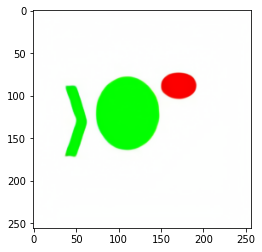

In [241]:
#@title Test recon
x = b['img'][0][jnp.newaxis]
z_logits = jax_enc_fn(jax_enc_params, x)
z = jnp.argmax(z_logits, axis=1)
z = jnp.transpose(jax.nn.one_hot(z, num_classes=8192), (0, 3, 1, 2))
B, D, H, W = z.shape
#z = jnp.reshape(jnp.repeat(jnp.reshape(z, (B, D, H*W))[:,:,::2], 2, axis = -1), (B,D,H,W))
x_stats = jax_dec_fn(jax_dec_params, z)
x_rec = unmap_pixels(jax.nn.sigmoid(x_stats[:, :3]))
x_rec = np.transpose((np.array(x_rec[0]) * 255).astype(np.uint8), (1, 2, 0))
plt.imshow(x_rec)

In [ ]:
import types
from typing import Optional, Mapping

class MultiHeadAttention(hk.Module):
  """Multi-headed attention mechanism.
  As described in the vanilla Transformer paper:
    "Attention is all you need" https://arxiv.org/abs/1706.03762
  """

  def __init__(
      self,
      num_heads: int,
      key_size: int,
      # TODO(romanring, tycai): migrate to a more generic `w_init` initializer.
      w_init_scale: float,
      value_size: Optional[int] = None,
      model_size: Optional[int] = None,
      name: Optional[str] = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads
    self.key_size = key_size
    self.value_size = value_size or key_size
    self.model_size = model_size or key_size * num_heads
    self.w_init = hk.initializers.VarianceScaling(w_init_scale)

  def __call__(
      self,
      query: jnp.ndarray,
      key: jnp.ndarray,
      value: jnp.ndarray,
      mask: Optional[jnp.ndarray] = None,
  ) -> jnp.ndarray:
    """Compute (optionally masked) MHA with queries, keys & values."""
    print(query.shape)
    query_heads = self._linear_projection(query, self.key_size, "query")
    key_heads = self._linear_projection(key, self.key_size, "key")
    value_heads = self._linear_projection(value, self.value_size, "value")
    print('qh', query_heads.shape)
    attn_logits = jnp.einsum("...thd,...Thd->...htT", query_heads, key_heads)
    sqrt_key_size = np.sqrt(self.key_size).astype(key.dtype)
    attn_logits = attn_logits / sqrt_key_size
    
    if mask is not None:
      print(mask.shape, attn_logits.shape)
      assert mask.shape == attn_logits.shape
      attn_logits = jnp.where(mask, attn_logits, -1e30)

    attn_weights = jax.nn.softmax(attn_logits)
    attn = jnp.einsum("...htT,...Thd->...thd", attn_weights, value_heads)
    # Concatenate attention matrix of all heads into a single vector.
    attn_vec = jnp.reshape(attn, (*value.shape[:-1], -1))

    return hk.Linear(self.model_size, w_init=self.w_init)(attn_vec)

  @hk.transparent
  def _linear_projection(
      self,
      x: jnp.ndarray,
      head_size: int,
      name: Optional[str] = None
  ) -> jnp.ndarray:
    y = hk.Linear(self.num_heads * head_size, w_init=self.w_init, name=name)(x)
    return y.reshape((*x.shape[:-1], self.num_heads, head_size))


class CausalSelfAttention(MultiHeadAttention):

    def __call__(
        self,
        query: jnp.ndarray,
        key: Optional[jnp.ndarray] = None,
        value: Optional[jnp.ndarray] = None,
        mask: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
      key = key if key is not None else query
      value = value if value is not None else query

      seq_len = query.shape[1]
      causal_mask = np.tril(np.ones((seq_len, seq_len)))
      mask = mask * causal_mask if mask is not None else causal_mask
      mask = jnp.tile(mask, [1, self.num_heads, 1,1])
      return super().__call__(query, key, value, mask)


class DenseBlock(hk.Module):
  """A 2-layer MLP which widens then narrows the input."""

  def __init__(self,
               init_scale: float,
               widening_factor: int = 4,
               name: Optional[str] = None):
    super().__init__(name=name)
    self._init_scale = init_scale
    self._widening_factor = widening_factor

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    hiddens = x.shape[-1]
    initializer = hk.initializers.VarianceScaling(self._init_scale)
    x = hk.Linear(self._widening_factor * hiddens, w_init=initializer)(x)
    x = jax.nn.gelu(x)
    return hk.Linear(hiddens, w_init=initializer)(x)

class net(hk.Module):
  def __init__(self,
               layer_size:int = 128,
               name=None):
      super().__init__(name=name)
      self.layer_size = layer_size

  def __call__(self, x:jnp.ndarray) -> jnp.ndarray:
      x = hk.Linear(self.layer_size)(x)
      x = jax.nn.gelu(x)
      x = CausalSelfAttention(num_heads=8, key_size=64, w_init_scale=0.2)(x)


      return x


def forward_fn(data, embedding_size: int):
  components = data['in']
  image_tokens = data['z_seq']
  # project the componets up, and tokens down into the same embedding space - it will be quite disjoint but meh
  embedded_components = jax.nn.gelu(hk.Linear(embedding_size)(components))
  embedded_tokens = jax.nn.gelu(hk.Linear(embedding_size)(image_tokens))
  
  combined_sequence = jnp.concatenate([embedded_tokens, embedded_components], 1) # B, T_embed+T_comp, embedding_size
  print(combined_sequence.shape)
  mask = mask=data['seq_mask'][:,:-1]
  print(mask.shape)
  if mask is not None:
      mask = mask[:, None, None, :]
  print(mask.shape)
  x = CausalSelfAttention(num_heads=8, key_size=64, w_init_scale=0.2)(combined_sequence, mask=mask) # TODO fix the mask


  return data

rng_key = jax.random.PRNGKey(42)
fwd = hk.transform(forward_fn)
params = fwd.init(rng=rng_key, data=b_train, embedding_size=64)

In [96]:
 



# def build_forward_fn(vocab_size: int, d_model: int, num_heads: int,
#                      num_layers: int, dropout_rate: float):
#   """Create the model's forward pass."""

#   def forward_fn(data: Mapping[str, jnp.ndarray],
#                  is_training: bool = True) -> jnp.ndarray:
#     """Forward pass."""
#     tokens = data['obs']
#     input_mask = jnp.greater(tokens, 0)
#     seq_length = tokens.shape[1]

#     # Embed the input tokens and positions.
#     embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
#     token_embedding_map = hk.Embed(vocab_size, d_model, w_init=embed_init)
#     token_embs = token_embedding_map(tokens)
#     positional_embeddings = hk.get_parameter(
#         'pos_embs', [seq_length, d_model], init=embed_init)
#     input_embeddings = token_embs + positional_embeddings

#     # Run the transformer over the inputs.
#     transformer = Transformer(
#         num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
#     output_embeddings = transformer(input_embeddings, input_mask, is_training)

#     # Reverse the embeddings (untied).
#     return hk.Linear(vocab_size)(output_embeddings)

#   return forward_fn
